## Advection Reaction Equations

Advection-reaction equations are transport equations with an addition reaction term (and potentially forcing). They are generally of the form


$$
\mathcal{L}u := \mathbf{b}\cdot\nabla u + cu = f \quad \mathbf{x}\in\Omega
$$

where $\mathbf{b}:\Omega\to\mathbb{R}^d$ is a given advection vector field, $c:\Omega\to\mathbb{R}$ is a given reaction scalar field and $f:\Omega\to\mathbb{R}$ is a given forcing scalar field. There are some assumptions that we additionaly make here on the various components of this partial differential equation (PDE)

1. $\Omega$ is an open, bounded Lipschitz domain
2. The dimension of the domain $\Omega$ is $d$ which is greater than equal $1$.
3. We search for a solution $u$ in the graph space, defined

$$
\mathcal{G}(\mathcal{L}, \Omega) := \{v\in L^2(\Omega): \mathcal{L}v\in L^2(\Omega)\}
$$

4. This asserts that the forcing term $f$ is also $L^2(\Omega)$.

### Spatial Discretisation

To begin our adventure into polygonal discontinuous Galerkin finite elements, we must begin with a spatial decomposition, namely a polygonal ($d=2$) or generally polyhedral ($d\ge3$). We define this to be $\mathcal{T}_h$. $\mathtt{reyna}$ does this in a simple manner. First, you define your domain, $\overline{\Omega}$ and then you discretise.

There are lots of simple built-in domains in $\mathtt{reyna}$ but we introduce the ```RectangleDomain``` to begin.

In [37]:
import numpy as np

from reyna.polymesher.two_dimensional.domains import RectangleDomain

domain = RectangleDomain(bounding_box=np.array([[0, 1], [0, 1]]))


There are a few things to note here;

1. Each of these built-in domains is a subclass of the abstract base class ```Domain```. This is used as a template for custom domains.
2. The ```bounding_box``` of a domain is a commonly used property to define the domain itself, this carries through to other domains, such as the ```CircleDomain``` where this bounding box is used to define the location and radius of the domain.
3. There is another optional variable missing, ```fixed_points```. This is for later use when generating domains with specific properties and can be used tangentially with the meshing algorithm and custom domain set-up to generate completely customisable domains.


Now we need to generate our polygonal mesh itself. This is done with the ```poly_mesher``` function. This is a Python adaptation of the PolyMesher package in MatLab. In our set-up, we have changed a few of the features to be more pythonic and user friendly.

To create a polygonal mesh (a ```PolyMesh``` object), we must simply call the ```poly_mesher``` function on our domain.

In [38]:
from reyna.polymesher.two_dimensional.main import poly_mesher

n_elements = 2048
poly_mesh = poly_mesher(domain, max_iterations=2, n_points=n_elements)

This variable ```poly_mesh``` is our final mesh! There are a few notes to make with the inputs to ```poly_mesher```;

1. The function ```poly_mesher``` runs Lloyd's algorithm in the background, which generates a centroidal Voronoi tessellation. This is good for making the elements roughly of equal size and shape, but this may not be desired; if this is the case, reduce the ```max_iterations``` variable to see more anisotropy.
2. The ```n_points``` variable dictates the number of elements in the mesh itself and therefore partly the size of the linear system.
3. There are two more keyword arguments; ```verbose``` and ```cleaned```. The variable ```verbode``` works as it sounds. The variable ```cleaned``` is more complicated. This variable adds additional cleaning steps to the mesh which remove small edges and tidy up the ```PolyMesh``` properties. Note that this means the mesh is no longer Voronoi, which may cause errors depending on the application.

### DGFEM Discretisation of $\mathcal{L}$


We begin by defining our finite element space, $\mathbb{V}_p$

$$
\mathbb{V}_p := \{u\in L^2(\Omega): u|_{\kappa}\in\mathbb{P}_p, \kappa\in\mathcal{T}_h\}
$$

which is the set of piecewise (potentially discontinuous) degree-$p$ polynomials with respect to the discretisation $\mathcal{T}_h$. Note that every element of our mesh will have a degree-$p$ polynomial defined over it; there is no $p$-adaptivity in $\mathtt{reyna}$ yet.


From here, we may define the local inflow and outflow boundaries for each element as

$$
\partial_-\kappa = \{\mathbf{x}\in\partial\kappa: \mathbf{b}\cdot\nu_{\kappa} < 0\} \quad \partial_+\kappa = \{\mathbf{x}\in\partial\kappa: \mathbf{b}\cdot\nu_{\kappa} \ge 0\}
$$

respectively, where $\nu$ is defined as the outward pointing unit normal vector (OPUNV) to $\partial\kappa$ at $\mathbf{x}\in\partial\kappa$.

We now quickly define the upwind jump of a function, $v$, on an edge between elements $e \subset \partial\kappa_1\cap\partial\kappa_2$ as $\left\lfloor\!\!\left\lfloor v \right\rfloor\!\!\right\rfloor = v|_{\kappa_1} - v|_{\kappa_2}$, where $\kappa_1, \kappa_2 \in\mathcal{T}_h$ such that $\kappa_1$ is upwind of $\kappa_2$. This meaning that $e\subset\partial_+\kappa_1$ and $e\subset\partial_-\kappa_2$. We note that we make the explicit assumption that each facet between elements is one-directional.

This is complicated but allows us to define our DGFEM formulation as: find $u_h\in\mathbb{V}_p$ such that

$$
\sum_{\kappa\in\mathcal{T}_h}\left[\int_{\kappa}(\mathbf{b}\cdot\nabla u_h + cu_h)v_h d\mathbf{x} - \int_{\partial_-\kappa\setminus\partial\Omega}\mathbf{b}\cdot\nu_{\kappa}\left\lfloor\!\!\left\lfloor u_h \right\rfloor\!\!\right\rfloor v_h ds - \int_{\partial_-\kappa\cap\partial_-\Omega} \mathbf{b}\cdot\nu_{\kappa}u_hv_h ds\right] = \int_{\Omega}fv_h d\mathbf{x} - \int_{\partial_-\Omega}\mathbf{b}\cdot\nu_{\kappa}g_Dv_h ds \quad \forall v_h\in\mathbb{V}_p
$$

In terms of this formulation, there is a lot that we don't get from generating the ```PolyMesh``` object in $\mathtt{reyna}$; we need the additional geometry and some boundary information. Luckily the boundary information is asserted through the advection field so this is done automatically. The remaining geometry, including the normal calculations, must be manually done. This has its perks later when considering custom schemes. Generating the corresponding geometry is a simple as

In [39]:
from reyna.geometry.two_dimensional.DGFEM import DGFEMGeometry

geometry = DGFEMGeometry(poly_mesh)

This ```geometry``` variable is an instance of the ```DGFEMGeometry``` dataclass and stores all the information that is needed in the DG solver.

## Solving a PDE

Finally, we are able to move on to solving a given PDE. We ahve to do this is two simple steps -- first create the fuctions for the know parameters and then we may place these into a solver.

### Inputting the Known Information

Finally, we are able to move on to solving a given PDE. First, we must generate an example as we need to define our variables, $\mathbf{b}$, $c$ and $f$. We may use simple lambda functions to do this. Each function must be able to take in a $\mathtt{numpy}$ array of 2D points i.e. of shape $(n, 2)$ and return either a $(n, 2)$ array for a vector field or a $(n,)$ array for a scalar field. This is indicated in the documentation for simplicity. We additionally have to define our boundary conditions. This is currently done through the use of Dirichlet boundary conditions so a further scalar field must be inputted to account for this.

We use an example where the solution is given by the function

$$
u(x, y) = \sin{(\pi x)}\sin{(\pi y)}
$$

This is paired with the coefficients in the lambda functions below.

In [40]:
advection = lambda x: np.ones(x.shape, dtype=float)
reaction = lambda x: np.pi ** 2 * np.ones(x.shape[0], dtype=float)
forcing = lambda x: np.pi * (np.cos(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1]) +
                             np.sin(np.pi * x[:, 0]) * np.cos(np.pi * x[:, 1])) + \
                    np.pi ** 2 * np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])

bcs = lambda x: np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])

We note that the boundary conditions function (```bcs```) is identical to the solution in this case (and more generally for certain smooth functions). Additionally, for more complciated functions, one has to watch out for $\mathtt{numba}$ compatability. $\mathtt{numba}$ is used primarily to speed up the repetative calls of the input functions, which can be overwhelmingly tedious for the computer in more complex scenarios and dominates the assembly time.

### DGFEM Solution

We finally may solve. This is done with the ```DGFEM``` object, first we initialise

In [41]:
from reyna.DGFEM.two_dimensional.main import DGFEM

dg = DGFEM(geometry, polynomial_degree=1)

This sets up the DGFEM object and any mild information associated with the assembly steps. From here, we may add our data

In [42]:
dg.add_data(
    advection=advection,
    reaction=reaction,
    dirichlet_bcs=bcs,
    forcing=forcing
)

In the background, this step also finalises all the boundary information required with the input of the advection and/or diffusion term (not included in this example).

Finally, we may assemble

In [43]:
dg.dgfem(solve=True)

There are a two options here for this method.

1. ```solve```: this variable determines whether the linear system is solved or just assembled. All of the matrix manipulations are done in a sparse manner to avoid too much overhead here.
2. ```verbose```: this variable does what is says on the tin, adds verbose or not -- currently either set to 0 or 1 with 1 indicating the assembly time.

## Using the solution

We have our solution now in the ```dg.solution``` property, but how do either calculate the various errors of such a function or even plot it? Luckily $\mathtt{reyna}$ can help with this.


### Plotting the Solution

$\mathtt{reyna}$ has the inbuilt funtion ```plot_DG``` to help with this.

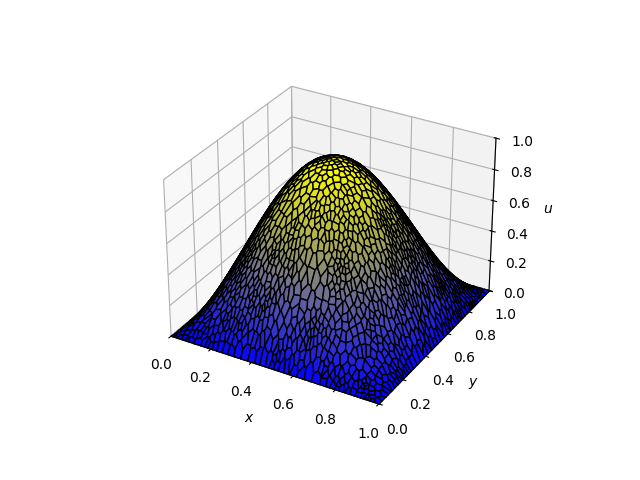

In [44]:
from reyna.DGFEM.two_dimensional.plotter import plot_DG

%matplotlib widget
plot_DG(dg.solution, dg.geometry, dg.polydegree)

If you just want to visualise the actual mesh itself, we have the function ```display_mesh``` in the $\mathtt{polymesher}$ submodule to use

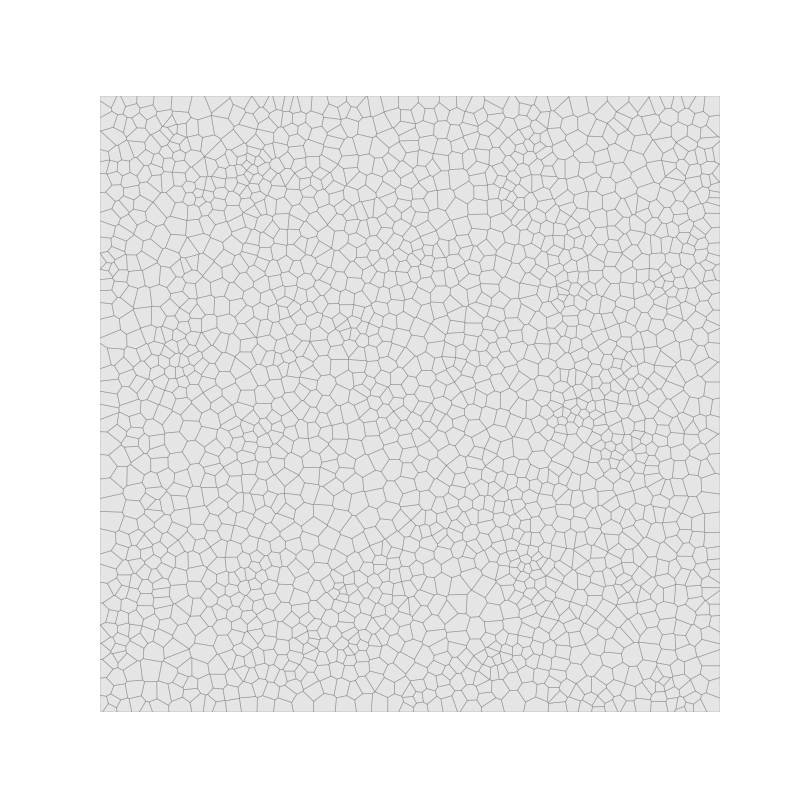

In [45]:
from reyna.polymesher.two_dimensional.visualisation import display_mesh

display_mesh(poly_mesh)

### Calculating Errors

As well as the plotting being simple, we can also calculate the errors from a property of the ```DGFEM``` object itself. We simply need to define the solution, the divergence of the advection term and the gradient of the exact solution. In return, we get the $L^2$- and dG- errors.

In [46]:
solution = lambda x: np.sin(np.pi * x[:, 0]) * np.sin(np.pi * x[:, 1])

Using these, we plug these into the ```.errors``` property.

In [47]:
l2_error, dg_error, _ = dg.errors(
                            exact_solution=solution,
                            div_advection=lambda x: np.zeros(x.shape[0]),
                        )

print(l2_error, dg_error)

0.0003152752065441157 0.004342634641052174


We see that there is also the room for a third error; this is the $H^1$-error and is outputted when there is a diffusion term when the input ```grad_exact_solution``` is fulled.

## Benchmarking

We finalise this exmaple with a benchmarking set-up for the transport code.

In [48]:
import time

n_elements = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]

h_s = []
dg_norms = []
l2_norms = []

geometry_times = []
initialisation_times = []
assembly_times = []

for n_r in n_elements:

    _time = time.time()

    poly_mesh = poly_mesher(domain, max_iterations=10, n_points=n_r)
    geometry = DGFEMGeometry(poly_mesh)

    geometry_times.append(time.time() - _time)
    _time = time.time()

    dg = DGFEM(geometry, polynomial_degree=1)
    dg.add_data(
        advection=advection,
        reaction=reaction,
        dirichlet_bcs=bcs,
        forcing=forcing
    )

    initialisation_times.append(time.time() - _time)
    _time = time.time()

    dg.dgfem(solve=True)

    assembly_times.append(time.time() - _time)

    l2_error, dg_error, _ = dg.errors(
                                exact_solution=solution,
                                div_advection=lambda x: np.zeros(x.shape[0]),
                            )

    h_s.append(geometry.h)
    l2_norms.append(l2_error)
    dg_norms.append(dg_error)

We see here that we can access the maximal cell diameter as a part of the ```DGFEMGeometry``` object. We now compare the errors to theoretical bests and consider the computational cost of increasing the number of elements.

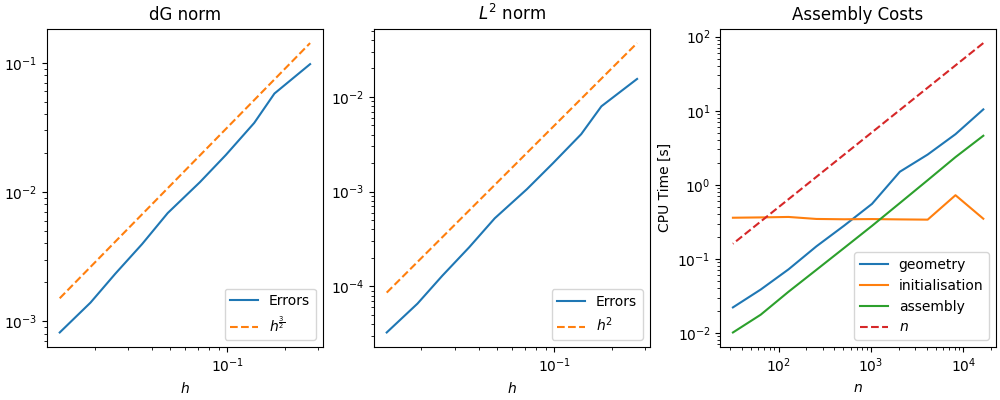

In [49]:
import matplotlib.pyplot as plt

x_ = np.linspace(h_s[-1], h_s[0], 100)
n_ = np.linspace(n_elements[-1], n_elements[0], 100)

fig, axes = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)

axes[0].plot(h_s, dg_norms, label='Errors')
axes[0].plot(x_, x_ ** 1.5, linestyle='--', label=r'$h^{\frac{3}{2}}$')

axes[0].legend(loc='lower right')
axes[0].set_title('dG norm')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$h$')

axes[1].plot(h_s, l2_norms, label='Errors')
axes[1].plot(x_, 0.5 * x_ ** 2.0, linestyle='--', label=r'$h^{2}$')

axes[1].legend(loc='lower right')
axes[1].set_title(r'$L^2$ norm')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r'$h$')

# Plotting the times
axes[2].plot(n_elements, geometry_times, label='geometry')
axes[2].plot(n_elements, initialisation_times, label='initialisation')
axes[2].plot(n_elements, assembly_times, label='assembly')

axes[2].plot(n_, 0.005 * n_, linestyle='--', label=r'$n$')

axes[2].legend(loc='lower right')
axes[2].set_title('Assembly Costs')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].set_xlabel(r'$n$')
axes[2].set_ylabel('CPU Time [s]')

plt.show()